In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


* Fazer auto correlação nos residuos e verificar se este é modelavel
* Residuos e outliers possuem simetria
* errando entre menos meio e meio

* log linear e usar linear 
* depois pegar o residuo do modelo linear e usar na arvore de decisao

In [474]:
dados = pd.read_csv("data/ca.csv")

C:\Users\kaio\AppData\Local\Temp\ipykernel_24276\2499396848.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("data/ca.csv")


In [475]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [476]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            605
Complemento        579320
Bairro               1176
Valor de Compra    740945
dtype: int64


In [477]:
dados['Estado - Sigla'].value_counts()

Estado - Sigla
BA    240700
CE    159862
PE    132842
MA     77758
RN     54326
PB     52367
PI     51767
AL     47837
SE     34418
Name: count, dtype: int64

## Pre-Processamento

In [478]:
print("tamanho dos dados antes do pre-processamento:",len(dados))
dados.head(5)


tamanho dos dados antes do pre-processamento: 851877


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,GASOLINA,02/01/2019,"4,49",NaN,R$ / litro,BRANCA
1,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,ETANOL,02/01/2019,"3,33",NaN,R$ / litro,BRANCA
2,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,"3,3",NaN,R$ / litro,BRANCA
3,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,"3,4",NaN,R$ / litro,BRANCA
4,NE,AL,ARAPIRACA,POSTO ARAPIRACA LTDA,12.451.076/0001-12,RUA EXPEDICIONARIOS BRASILEIROS,252,NaN,CENTRO,57300-590,GASOLINA,02/01/2019,"4,699","3,8906",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


In [479]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
dados = dados[dados['Estado - Sigla'] == 'CE']


dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados.head()


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,Nome da Rua,Bairro,Cep,Produto,Valor de Venda,Unidade de Medida,Bandeira,Ano,Mes
Data da Coleta,,,,,,,,,,,,,
2019-01-02,NE,CE,CANINDE,POSTO SIM LTDA,ESTRADA BR-020 KM 305,JUBAIA,62700-000,GASOLINA,4.590,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,POSTO SIM LTDA,RUA EUCLIDES BARROSO,SANTA LUZIA,62700-000,GASOLINA,4.499,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,J & J PESSOA COMERCIO DE COMBUSTIVEIS LTDA,AVENIDA PERIMETRAL,CANINDEZINHO,62700-000,GASOLINA,4.599,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,JULIENIA SILVA PESSOA,RUA JOSE VELOSO JUCA,PALESTINA,62700-000,GASOLINA,4.599,R$ / litro,BRANCA,2019.0,1.0
2019-01-02,NE,CE,CANINDE,POSTO ESTRELA COMERCIO DE COMBUSTIVEIS LTDA,AVENIDA LUCIANO MAGALHAES,BELA VISTA,62700-000,GASOLINA,4.649,R$ / litro,RAIZEN,2019.0,1.0


In [480]:
dados['Municipio'].value_counts()

# Municipios que possuem alto valor
# - ITAPIPOCA
# - CANINDE
# - CRATEUS


Municipio
FORTALEZA            21713
CAUCAIA               4558
SOBRAL                2616
MARACANAU             2473
JUAZEIRO DO NORTE     2196
CRATO                 2170
IGUATU                1652
LIMOEIRO DO NORTE     1394
QUIXADA               1390
ITAPIPOCA             1232
ICO                   1222
CANINDE               1147
CRATEUS               1131
ARACATI                 39
Name: count, dtype: int64

In [481]:
# Manter apenas as colunas 'Municipio' e 'Valor de Venda'
dados = dados[['Municipio', 'Valor de Venda']]
print(len(dados))

# Filtrar os dados para incluir apenas os municípios de Crato, Juazeiro e Barbalha
municipios_desejados = ['MARACANAU', 'FORTALEZA','CAUCAIA']
dados = dados[dados['Municipio'].isin(municipios_desejados)]

# Reamostrar os dados semanalmente, alinhando as datas ao início do intervalo
dados = dados.groupby('Municipio').resample('W-MON', label='left').mean()

# Preencher os valores NaN com o valor anterior para evitar perda de dados
dados = dados.groupby('Municipio').fillna(method='ffill')

# Resetar o índice e reconfigurar a 'Data da Coleta' como índice
dados = dados.reset_index()
dados.set_index('Data da Coleta', inplace=True)

# Ordenar os dados pelo índice
dados = dados.sort_index()

# Adicionar as colunas 'Ano' e 'Mes'
dados['Ano'] = dados.index.year.astype(float)
dados['Mes'] = dados.index.month.astype(float)


44933


C:\Users\kaio\AppData\Local\Temp\ipykernel_24276\3256400274.py:13: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')
C:\Users\kaio\AppData\Local\Temp\ipykernel_24276\3256400274.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')


In [482]:
dados['Municipio'].value_counts()

Municipio
CAUCAIA      261
FORTALEZA    261
MARACANAU    261
Name: count, dtype: int64

In [483]:
print("tamanho dos dados após pre-processamento:",len(dados))
dados.head(5)

tamanho dos dados após pre-processamento: 783


,Municipio,Valor de Venda,Ano,Mes
Data da Coleta,,,,
2018-12-31,CAUCAIA,4.342619,2018.0,12.0
2018-12-31,FORTALEZA,4.293604,2018.0,12.0
2018-12-31,MARACANAU,4.252600,2018.0,12.0
2019-01-07,CAUCAIA,4.255571,2019.0,1.0
2019-01-07,FORTALEZA,4.216802,2019.0,1.0


In [484]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd

# Definindo colunas categóricas e numéricas
categorical_features = ['Municipio']
numeric_features = ['Ano', 'Mes','Valor de Venda']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']

# Determinando os tamanhos dos conjuntos de treino, validação e teste
n = len(X)
train_size = int(n * 0.72)  # 72% para treino
val_size = int(n * 0.18)    # 18% para validação
test_size = n - train_size - val_size  # 10% para teste

# Dividindo os dados
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Configurando o pré-processador para aplicar OneHotEncoding apenas nas colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Mantém as features numéricas na escala original
)

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados de treino e transformando
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Obtendo os nomes das colunas após o OneHotEncoding e mantendo as colunas numéricas
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(categorical_feature_names) + numeric_features

# Convertendo as matrizes para DataFrames e ajustando os índices para frequência diária
X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=all_feature_names,
                                      index=X_train.index)

X_val_transformed_df = pd.DataFrame(X_val_transformed, 
                                    columns=all_feature_names,
                                    index=X_val.index)

X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=all_feature_names,
                                     index=X_test)

# Verificando os tamanhos dos conjuntos e o ajuste de índices
print("Treinamento:", X_train_transformed_df.shape)
print("Validação:", X_val_transformed_df.shape)
print("Teste:", X_test_transformed_df.shape)

'''# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais
dados_treino = X_train.copy()
dados_val = X_val.copy()

dados_treino['Valor de Venda'] = y_train
dados_val['Valor de Venda'] = y_val'''


Treinamento: (563, 6)
Validação: (140, 6)
Teste: (80, 6)


"# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais\ndados_treino = X_train.copy()\ndados_val = X_val.copy()\n\ndados_treino['Valor de Venda'] = y_train\ndados_val['Valor de Venda'] = y_val"

In [485]:
# Concatenando os DataFrames transformados de treinamento e validação
X_train_val = pd.concat([X_train, X_val])

# Concatenando os valores de y correspondentes para treinamento e validação
y_train_val_combined = pd.concat([y_train, y_val])

# Adicionando a coluna 'Valor de Venda' ao DataFrame combinado
X_train_val['Valor de Venda'] = y_train_val_combined.values

# Verificando o resultado
display(X_train_val.head())
print("Tamanho do DataFrame combinado:", X_train_val.shape)


,Municipio,Ano,Mes,Valor de Venda
Data da Coleta,,,,
2018-12-31,CAUCAIA,2018.0,12.0,4.342619
2018-12-31,FORTALEZA,2018.0,12.0,4.293604
2018-12-31,MARACANAU,2018.0,12.0,4.252600
2019-01-07,CAUCAIA,2019.0,1.0,4.255571
2019-01-07,FORTALEZA,2019.0,1.0,4.216802


Tamanho do DataFrame combinado: (703, 4)


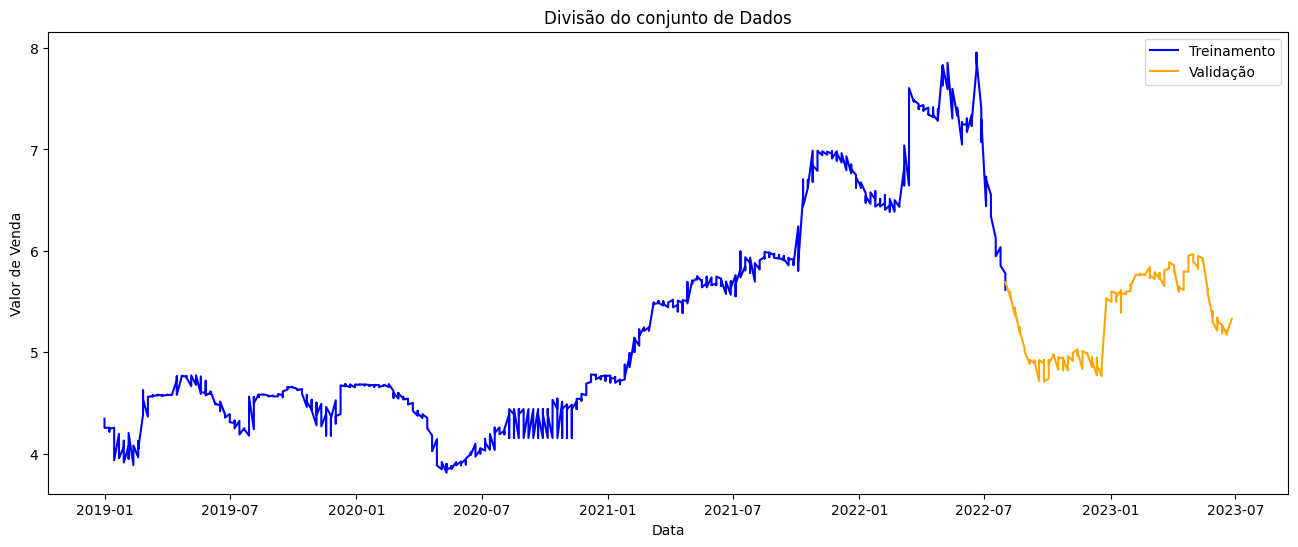

In [486]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y_train,label='Treinamento', color='blue')
plt.plot(y_val,label='Validação', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

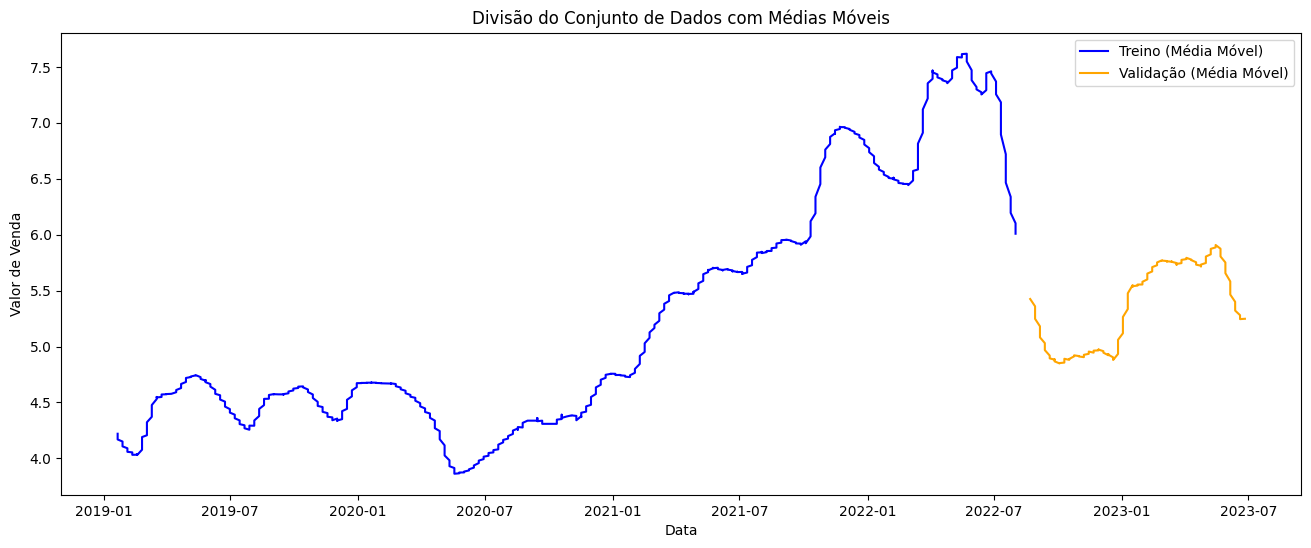

In [487]:
# Aplicando médias móveis com uma janela de 10 períodos (por exemplo)
y_train_rolling = y_train.rolling(window=10).mean()
y_val_rolling = y_val.rolling(window=10).mean()

# Plotando as médias móveis
plt.figure(figsize=(16, 6))

plt.title("Divisão do Conjunto de Dados com Médias Móveis")

plt.plot(y_train_rolling, label='Treino (Média Móvel)', color='blue')
plt.plot(y_val_rolling, label='Validação (Média Móvel)', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()


# log linear e usar linear 
# depois pegar o residuo do modelo linear e usar na arvore de decisao

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

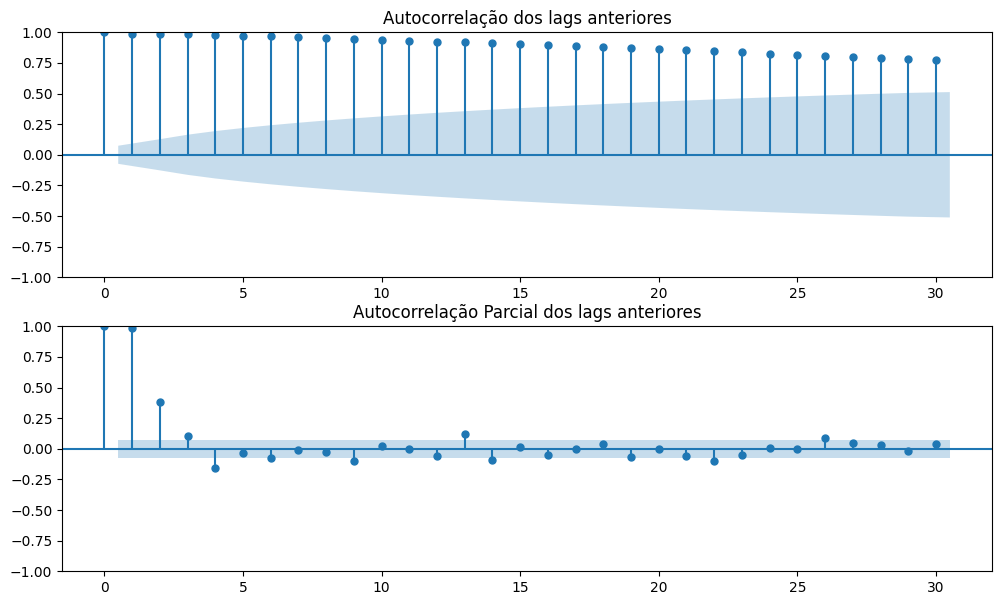

In [488]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X_train_val['Valor de Venda'], lags=30, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X_train_val['Valor de Venda'], lags=30, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show


Lags Significantes: [1, 2, 3, 4, 5, 6, 9, 13, 18, 21, 22, 23, 26, 27, 28]


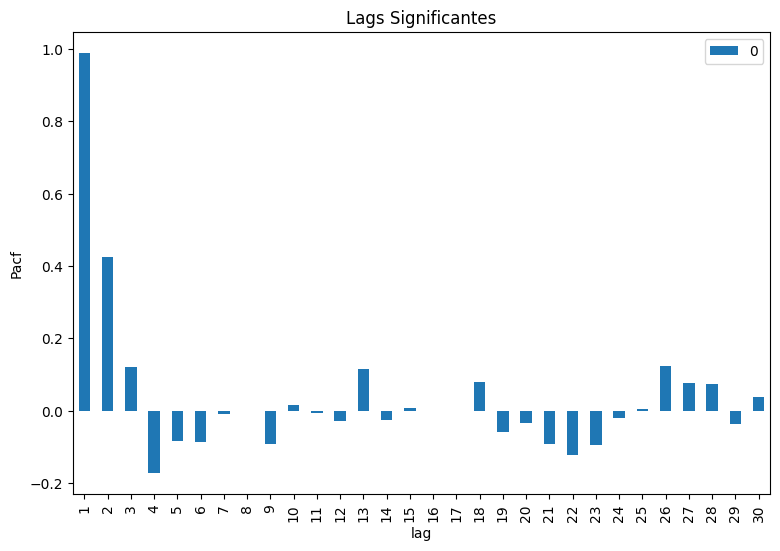

In [489]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 30, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Modelagem

In [490]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
def TheilU(y_true, y_pred):
    fResiduals2 = y_true[1:].subtract(y_pred[1:])
    fResiduals2 = fResiduals2.multiply(fResiduals2)
    rwForecasts = y_true.shift(1)
    rwResiduals2 = y_true[1:].subtract(rwForecasts[1:])
    rwResiduals2 = rwResiduals2.multiply(rwResiduals2)
    theil = fResiduals2.sum()/rwResiduals2.sum()
    return theil

models_label_r = []
df_teste  = pd.DataFrame()
def ResidualForModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label_r.append(formalism)
        y_pred_t = y_pred
        df_teste[formalism] = y_pred_t
    return df_teste

models_label = []
models_MAPE = []
models_MAE = []
models_R2 = []
models_theil = []

def computeAccuracyModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label.append(formalism)
        y_pred_test = y_pred
        models_MAE.append(mean_absolute_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        # models_theil.append(TheilU(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_MAPE.append(mean_absolute_percentage_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_R2.append(r2_score(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        
    df = pd.DataFrame({'model': models_label, 
                       'MAE': models_MAE,
                       'MAPE': models_MAPE,
                       'R2': models_R2,
                       # 'theil': models_theil
                       })
    print(" --------------------------- Medidas de Erro para os Modelos  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending = True))
    

In [491]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    lowerIndex = 0
    x = df[y]
    
    if previousData is not None:
        x = pd.concat([previousData[y], x])
        lowerIndex = previousData.shape[0]
    
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag)[lowerIndex:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df

# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
X_train_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_train_transformed_df, 
    dropna=True
)

X_val_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val_transformed_df, 
    dropna=True
)

X_test_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_test_transformed_df, 
    dropna=True
)

X_val = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val, 
    dropna=True
)

y_train = X_train_transformed_df['Valor de Venda']
y_val = X_val_transformed_df['Valor de Venda']
y_test = X_test_transformed_df['Valor de Venda']



X_val_transformed_df = X_val_transformed_df.drop(columns=['Valor de Venda'])
X_test_transformed_df = X_test_transformed_df.drop(columns=['Valor de Venda'])
X_train_transformed_df = X_train_transformed_df.drop(columns=['Valor de Venda'])


# Regression Linear Model

In [492]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

model_lr = {
    'Linear Regression': LinearRegression()
}

param_grids_lr = {

    'Linear Regression': {
        'fit_intercept': [True, False]
    }
}

grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring=r2_score,  # Métrica a ser otimizada
    cv=5,  # Número de folds para validação cruzada
    n_jobs=-1  # Utilizar todos os núcleos do processador
)
grid_search_lr.fit(X_train_transformed_df, y_train)

y_pred_lr =  grid_search_lr.best_estimator_.predict(X_val_transformed_df)
y_val_series = y_val.values.ravel()  # Convertendo y_val para um array 1D


# MSE antes MSE (Mean Squared Error): 0.013397830987249398


mse = mean_squared_error(y_val_series, y_pred_lr)
print(f"MSE (Mean Squared Error): {mse}")

computeAccuracyModels(models=[grid_search_lr.best_estimator_],y_pred=y_pred_lr)


MSE (Mean Squared Error): 0.013397830987249398
 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
              model       MAE      MAPE        R2
0  LinearRegression  0.081432  0.015013  0.904045


c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [493]:
df_previsoes = pd.DataFrame({
    'Valor Real': y_val_series,
    'Valor Previsto_LR': y_pred_lr
}, index=y_val.index)

# Supondo que 'Municipio' esteja em X_val
# Adicionando a coluna 'Municipio' ao DataFrame df_comparacao
df_previsoes['Municipio'] = X_val['Municipio']

df_residuos = pd.DataFrame()
df_residuos['resid_LR'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_LR'])
df_residuos['Municipio'] = X_val['Municipio']



In [494]:
display(df_previsoes.head(5))

,Valor Real,Valor Previsto_LR,Municipio
Data da Coleta,,,
2022-10-10,4.967500,4.850394,MARACANAU
2022-10-10,4.976429,4.956024,CAUCAIA
2022-10-10,4.970851,5.049700,FORTALEZA
2022-10-17,4.825000,4.974324,MARACANAU
2022-10-17,4.950375,4.926980,FORTALEZA


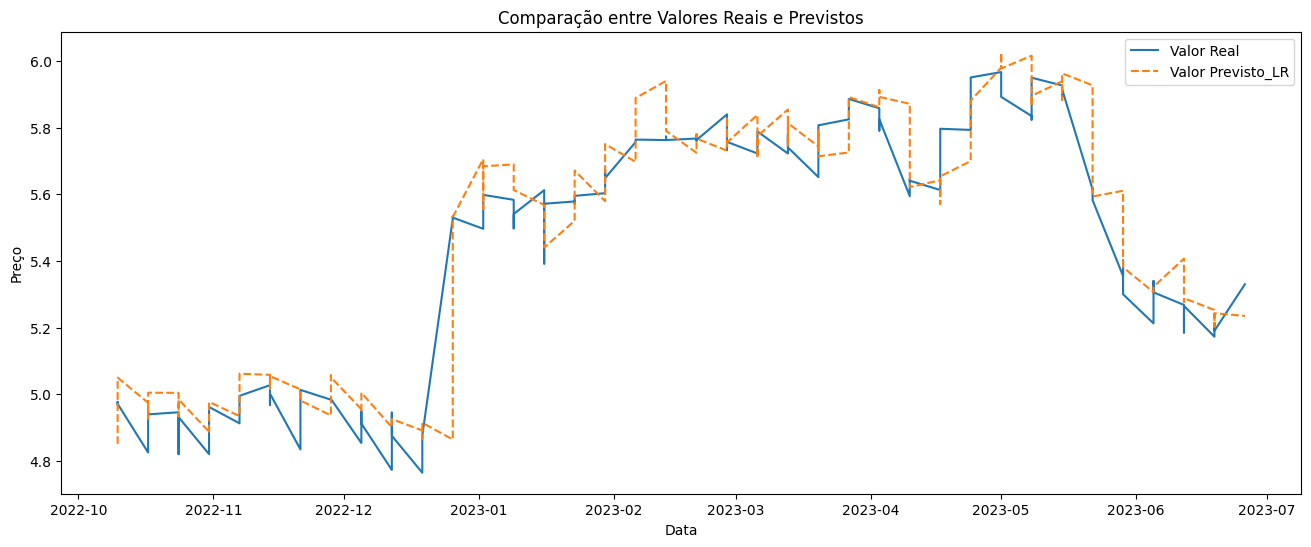

In [495]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_LR'], label='Valor Previsto_LR', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

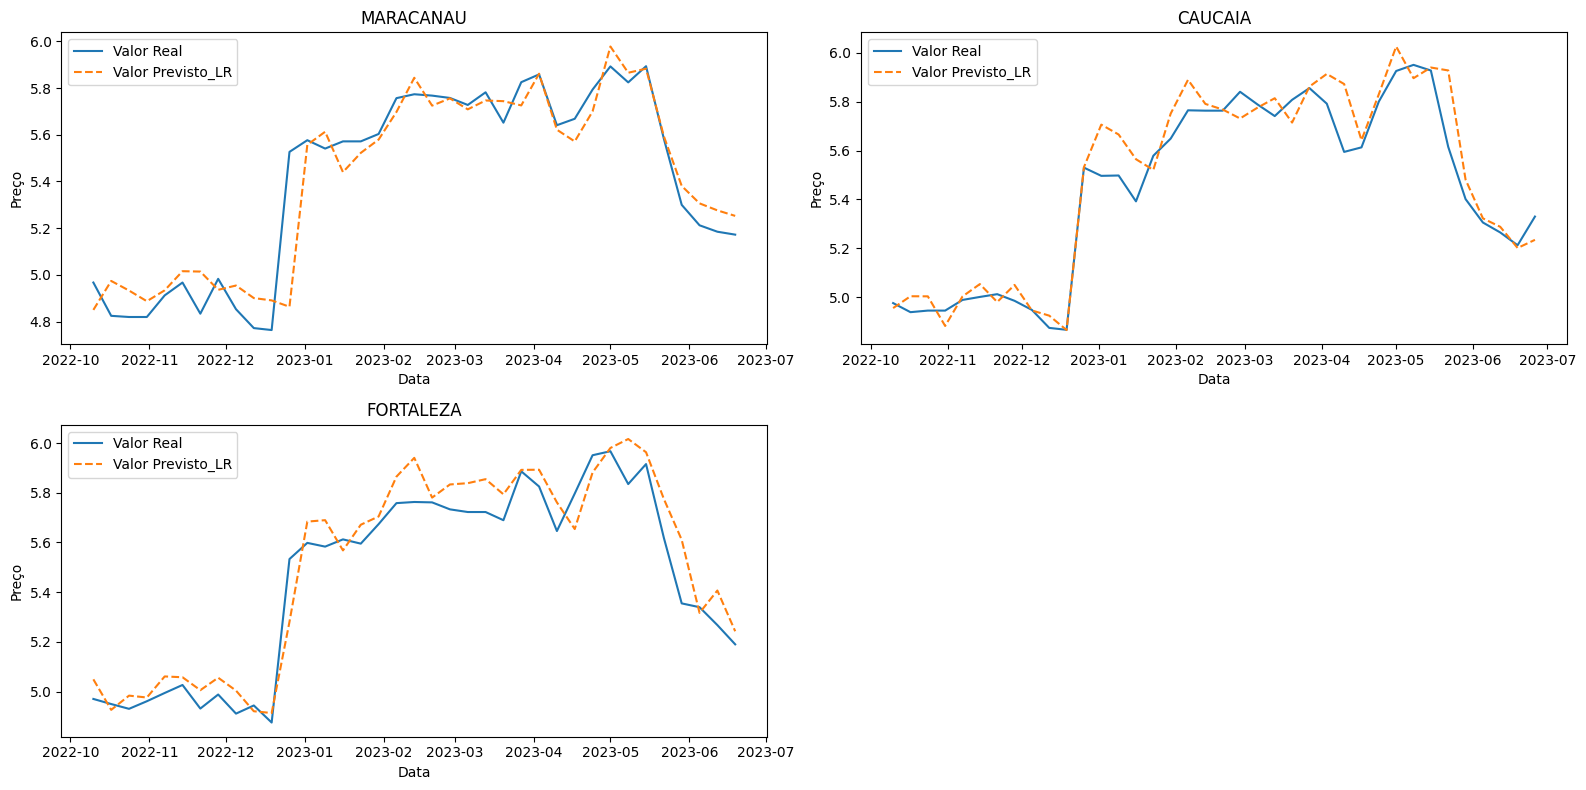

In [496]:
municipios = df_previsoes['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # Número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas, ajustado para o número total de municípios

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Achatar a matriz de eixos para iteração

for i, municipio in enumerate(municipios):
    df_municipio = df_previsoes[df_previsoes['Municipio'] == municipio]
    
    axes[i].plot(df_municipio['Valor Real'], label='Valor Real')
    axes[i].plot(df_municipio['Valor Previsto_LR'], label='Valor Previsto_LR', linestyle='--')
    axes[i].set_title(f'{municipio}')
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Preço')
    axes[i].legend()

# Removendo eixos vazios, caso haja
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Residuos do Modelo

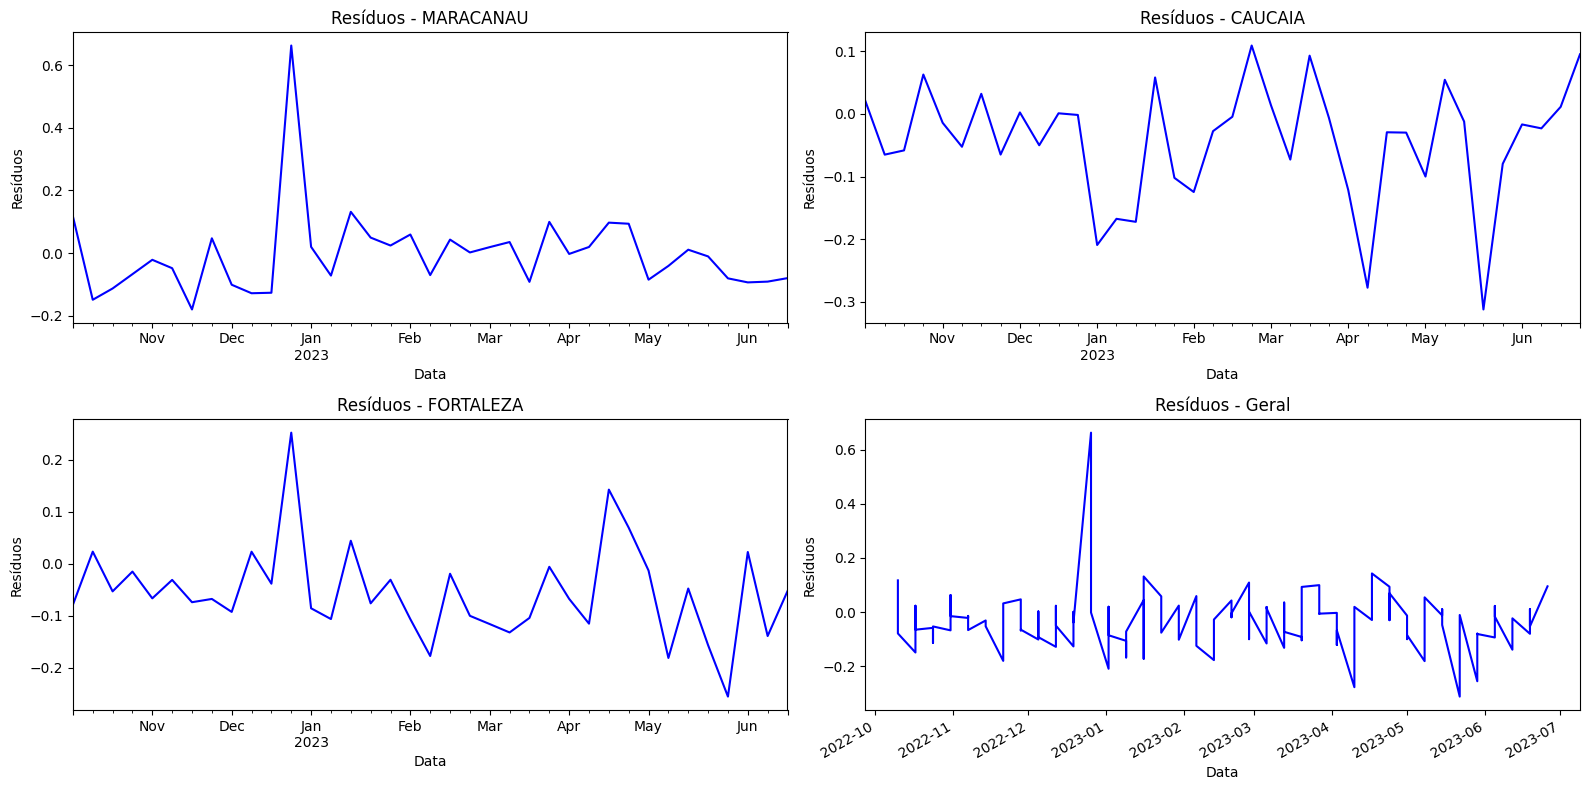

In [497]:
# Supondo que o nome da coluna com os municípios seja 'Municipio'
municipios = df_residuos['Municipio'].unique()

# Definindo o número de subplots
n_municipios = len(municipios) + 1  # Adiciona 1 para incluir o gráfico geral
n_cols = 2  # Definindo o número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas necessário

# Criando a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Garantir que 'axes' seja sempre uma matriz 2D, mesmo com poucos subplots
if n_rows == 1:
    axes = [axes]  # Se houver apenas uma linha, transforme axes em uma lista

# Definindo os gráficos manualmente
# Gráfico para o primeiro município
df_municipio1 = df_residuos[df_residuos['Municipio'] == municipios[0]]
df_municipio1[['resid_LR']].plot(ax=axes[0, 0], color='b', legend=False)
axes[0, 0].set_title(f"Resíduos - {municipios[0]}")
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduos')

# Gráfico para o segundo município
df_municipio2 = df_residuos[df_residuos['Municipio'] == municipios[1]]
df_municipio2[['resid_LR']].plot(ax=axes[0, 1], color='b', legend=False)
axes[0, 1].set_title(f"Resíduos - {municipios[1]}")
axes[0, 1].set_xlabel('Data')
axes[0, 1].set_ylabel('Resíduos')

# Se houver um terceiro município, plotá-lo na segunda linha
if n_municipios > 2:
    df_municipio3 = df_residuos[df_residuos['Municipio'] == municipios[2]]
    df_municipio3[['resid_LR']].plot(ax=axes[1, 0], color='b', legend=False)
    axes[1, 0].set_title(f"Resíduos - {municipios[2]}")
    axes[1, 0].set_xlabel('Data')
    axes[1, 0].set_ylabel('Resíduos')

# Plotando o gráfico geral
df_residuos[['resid_LR']].plot(ax=axes[1, 1], color='b', legend=False)
axes[1, 1].set_title("Resíduos - Geral")
axes[1, 1].set_xlabel('Data')
axes[1, 1].set_ylabel('Resíduos')

# Removendo eixos vazios, caso haja
for j in range(n_municipios, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


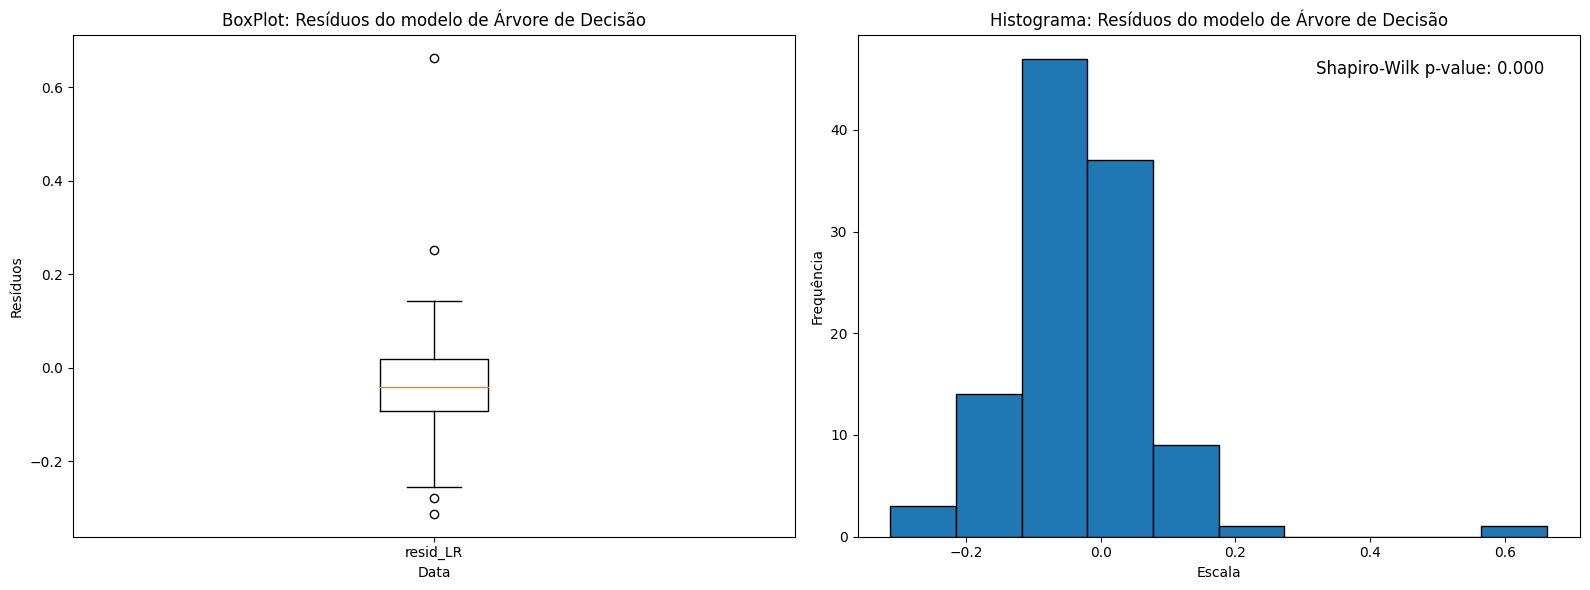

In [498]:
from scipy.stats import shapiro

# Calcular os resíduos

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
axes[0].boxplot(df_residuos[['resid_LR']].iloc[1:, :], labels=['resid_LR'])
axes[0].set_title("BoxPlot: Resíduos do modelo de Árvore de Decisão")
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Resíduos')

# Plotar o histograma no segundo subplot
df_residuos['resid_LR'].plot(kind='hist', ax=axes[1], edgecolor='black')
axes[1].set_title("Histograma: Resíduos do modelo de Árvore de Decisão")
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('Frequência')

# Realizar o teste de Shapiro-Wilk e adicionar o valor p ao histograma
stat, p_value = shapiro(df_residuos['resid_LR'].dropna())
axes[1].text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


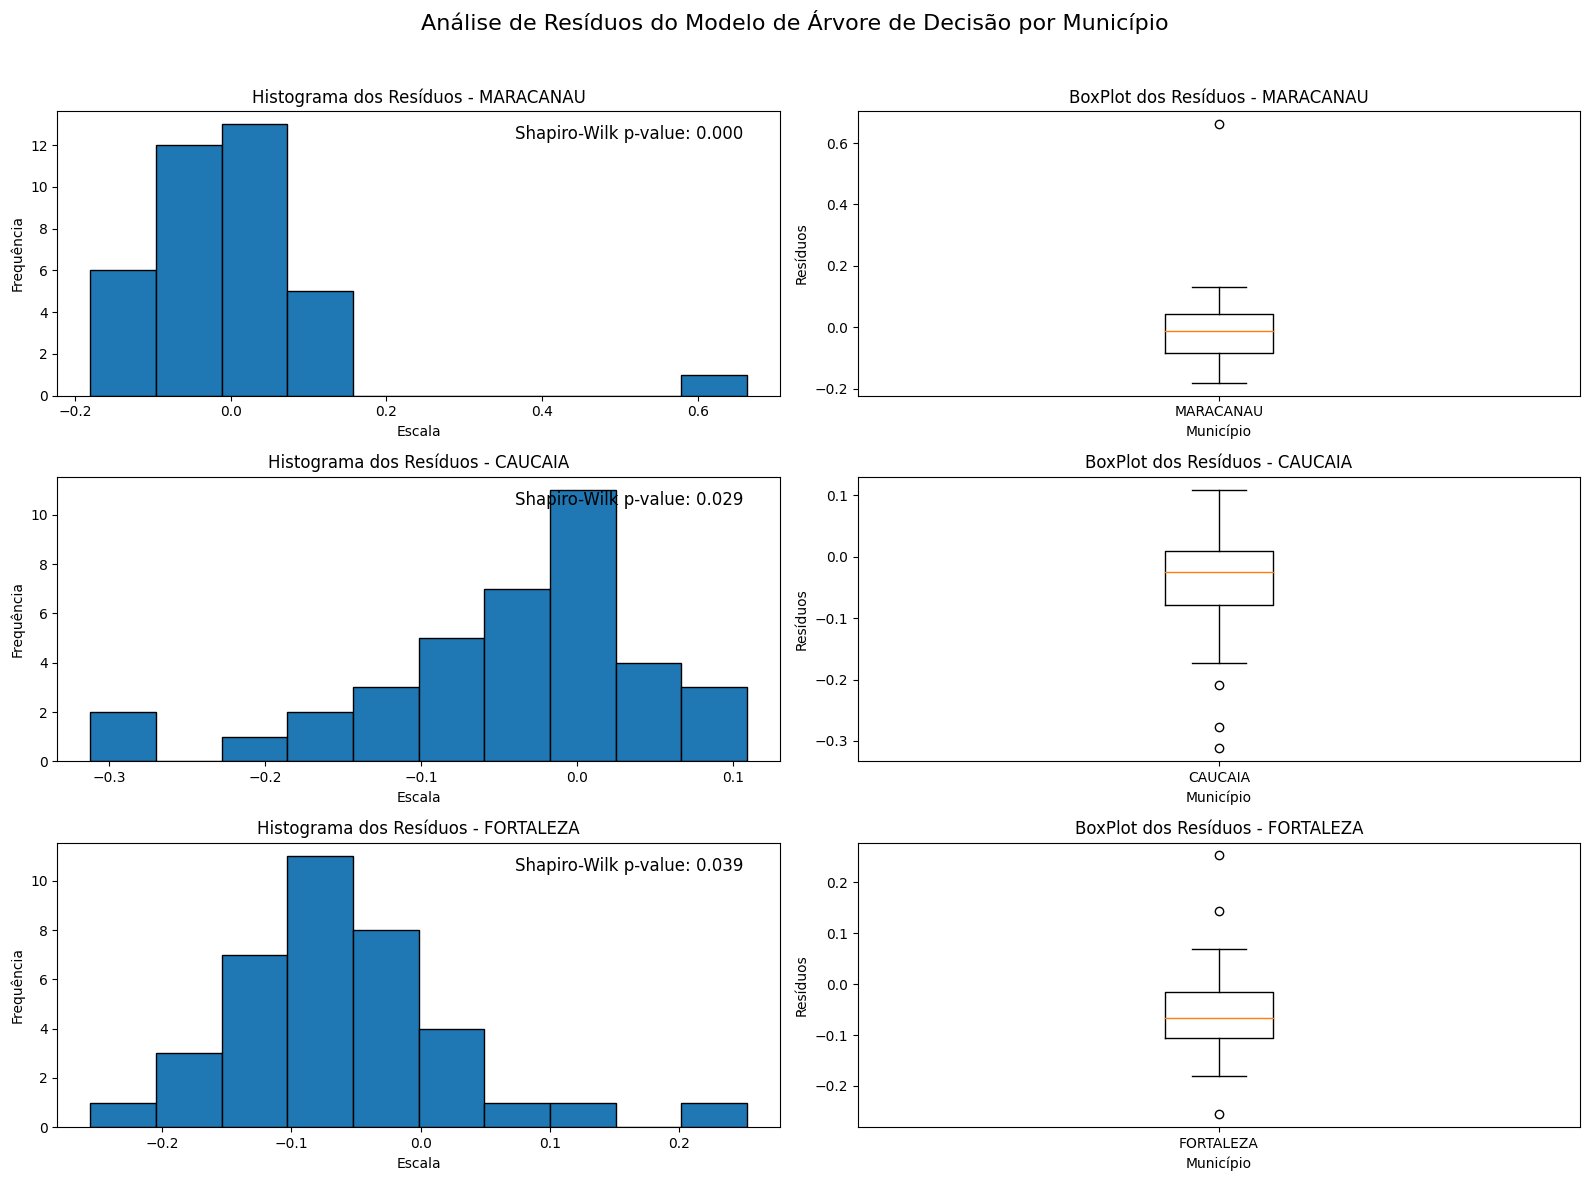

In [499]:
from scipy.stats import shapiro

# Supondo que o nome da coluna com os municípios seja 'Municipio'
municipios = df_residuos['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # 2 gráficos por linha (histograma e boxplot)
n_rows = n_municipios  # Uma linha por município

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

for i, municipio in enumerate(municipios):
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio]
    
    # Plotando o histograma dos resíduos
    ax_hist = axes[i, 0]
    df_municipio['resid_LR'].plot(kind='hist', ax=ax_hist,edgecolor='black')
    ax_hist.set_title(f"Histograma dos Resíduos - {municipio}")
    ax_hist.set_xlabel('Escala')
    ax_hist.set_ylabel('Frequência')

    # Realizando o teste de Shapiro-Wilk
    stat, p_value = shapiro(df_municipio['resid_LR'].dropna())
    ax_hist.text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=ax_hist.transAxes,
                 fontsize=12, verticalalignment='top', horizontalalignment='right')

    # Plotando o boxplot dos resíduos
    ax_box = axes[i, 1]
    ax_box.boxplot(df_municipio['resid_LR'].dropna(), labels=[f'{municipio}'])
    ax_box.set_title(f"BoxPlot dos Resíduos - {municipio}")
    ax_box.set_xlabel('Município')
    ax_box.set_ylabel('Resíduos')

plt.suptitle("Análise de Resíduos do Modelo de Árvore de Decisão por Município", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Modelagem dos residuos

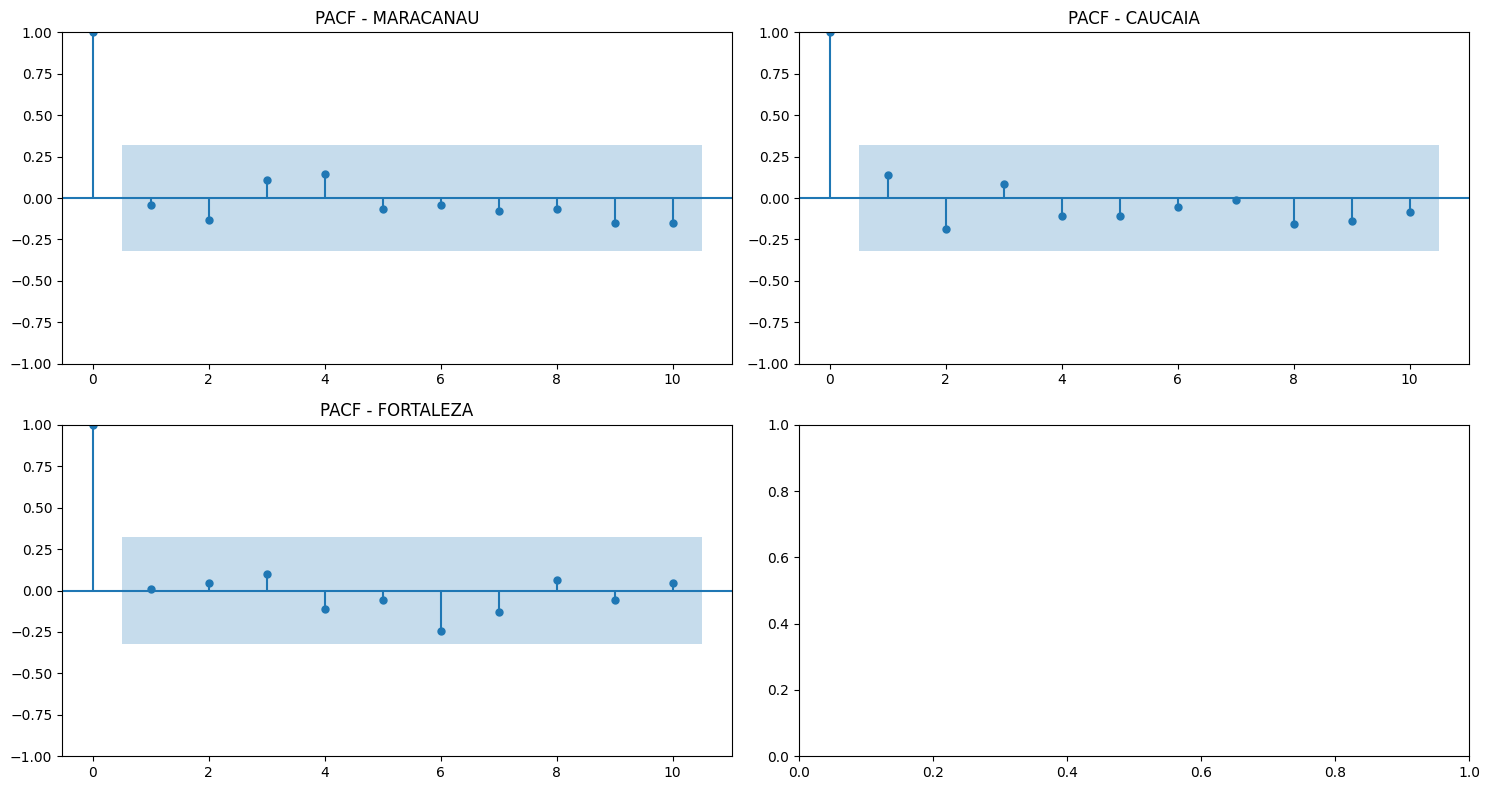

In [500]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Lista de municípios únicos no DataFrame
municipios = df_residuos['Municipio'].unique()

# Definindo o número de colunas e linhas para o layout dos subplots
n_cols = 2  # número de colunas
n_rows = (len(municipios) + 1) // n_cols  # número de linhas

# Criando uma figura para os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Iterando sobre os municípios e subplots
for i, municipio in enumerate(municipios):
    # Filtrando os resíduos para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio]
    
    # Identificando a posição do subplot
    row = i // n_cols
    col = i % n_cols
    
    # Plotando a PACF no subplot correspondente
    plot_pacf(df_municipio['resid_LR'], lags=10, ax=axes[row, col], title=f'PACF - {municipio}')
    
# Ajustando o layout para não sobrepor os subplots
plt.tight_layout()
plt.show()


In [501]:
from statsmodels.tsa.ar_model import AutoReg

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Modelando os resíduos
    model_residuos_pacf = AutoReg(df_municipio['resid_LR'], lags=[1, 2]).fit()
    
    # Prevendo os resíduos
    df_municipio['resid_pred_pacf'] = model_residuos_pacf.predict(start=2, end=len(df_municipio)-1)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_residuos_pacf
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_pacf']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_pacf'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

df_previsoes['Valor Ajustado_LR_PACF'] = df_previsoes['Valor Previsto_LR'] + df_residuos['resid_pred_pacf']


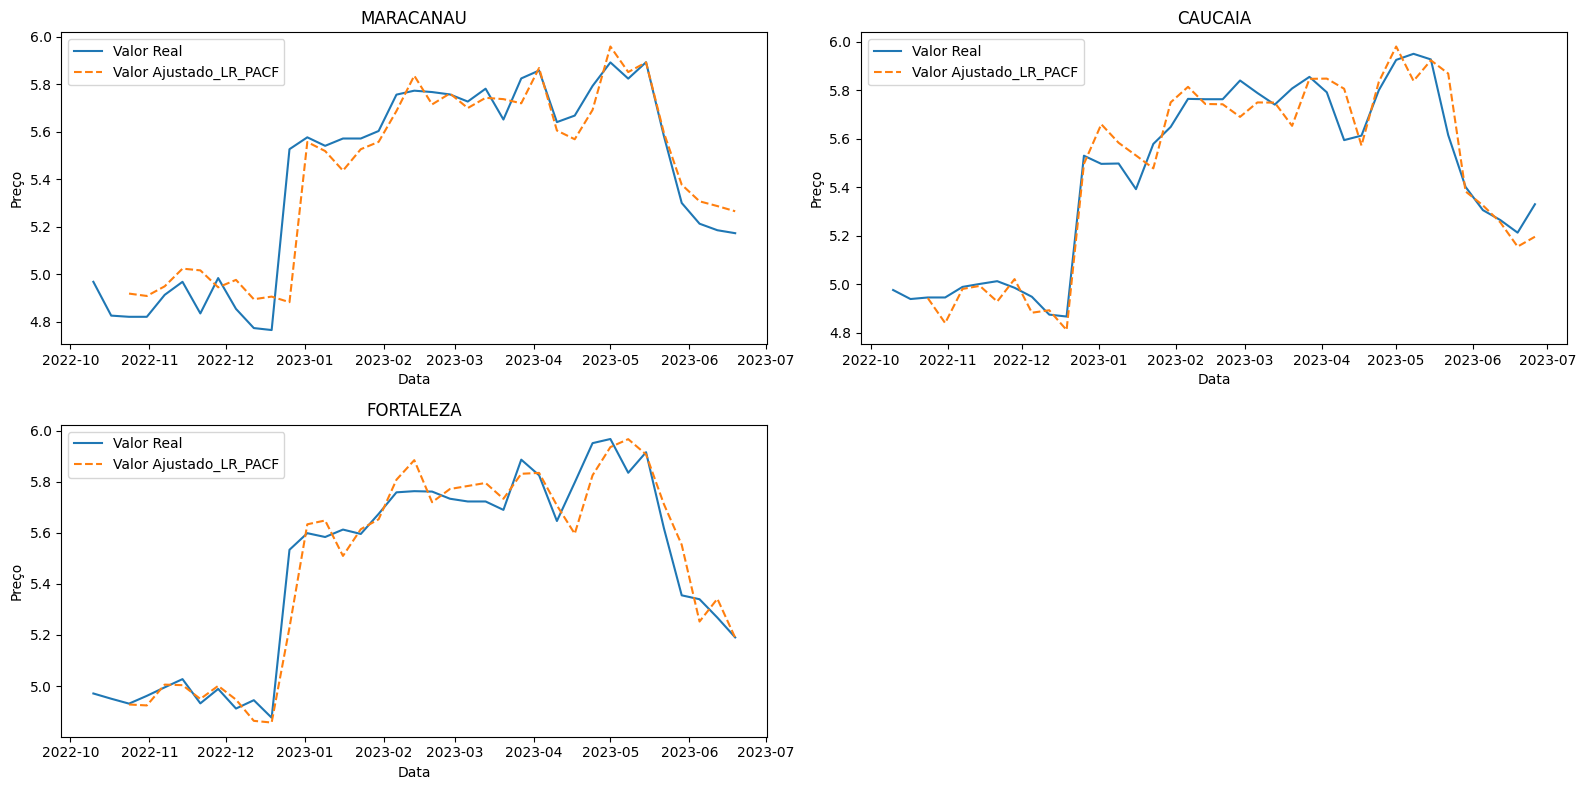

In [502]:
municipios = df_previsoes['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # Número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas, ajustado para o número total de municípios

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Achatar a matriz de eixos para iteração

for i, municipio in enumerate(municipios):
    df_municipio = df_previsoes[df_previsoes['Municipio'] == municipio]
    
    axes[i].plot(df_municipio['Valor Real'], label='Valor Real')
    axes[i].plot(df_municipio['Valor Ajustado_LR_PACF'], label='Valor Ajustado_LR_PACF', linestyle='--')
    axes[i].set_title(f'{municipio}')
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Preço')
    axes[i].legend()

# Removendo eixos vazios, caso haja
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Decision Tree Model

In [503]:
from sklearn.tree import DecisionTreeRegressor

model_DT = {
    'Decision Tree': DecisionTreeRegressor()
}

param_grids_DT = {

    'Decision Tree': {

    }
}

grid_search_DT = GridSearchCV(
    estimator= DecisionTreeRegressor(),
    param_grid=param_grids_DT['Decision Tree'],
    scoring=r2_score,  # Métrica a ser otimizada
    cv=5,  # Número de folds para validação cruzada
    n_jobs=-1  # Utilizar todos os núcleos do processador
)
grid_search_DT.fit(X_train_transformed_df, y_train.values.ravel())

y_pred_DT =  grid_search_DT.best_estimator_.predict(X_val_transformed_df)


# MSE antes MSE (Mean Squared Error): 0.048530544268560856

mse = mean_squared_error(y_val_series, y_pred_DT)
print(f"MSE (Mean Squared Error): {mse}")

computeAccuracyModels(models=[grid_search_DT.best_estimator_],y_pred=y_pred_DT)


df_previsoes['Valor Previsto_DT'] = y_pred_DT
df_residuos['resid_DT'] = df_previsoes['Valor Real'].subtract(df_previsoes['Valor Previsto_DT'])



MSE (Mean Squared Error): 0.05199745832231457
 --------------------------- Medidas de Erro para os Modelos  --------------------------- 
                   model       MAE      MAPE        R2
0       LinearRegression  0.081432  0.015013  0.904045
1  DecisionTreeRegressor  0.174342  0.032442  0.627594


c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


In [504]:
'''
from sklearn.tree import DecisionTreeRegressor

# Inicializando o modelo
reg = DecisionTreeRegressor()

# Treinando o modelo
reg.fit(X_train_transformed_df, y_train.values.ravel())  # Convertendo y_train para um array 1D

# Fazendo previsões
y_pred_lr = reg.predict(X_val_transformed_df)


# Calculando a diferença entre os valores reais e previstos
diferenca = mean_squared_error(y_val_series, y_pred_lr)

# Se você precisar imprimir ou fazer algo com a diferença
print(f"MSE (Mean Squared Error): {diferenca}")
computeAccuracyModels(models=reg,y_pred=y_pred_lr)

# Fazendo previsões
predicao = reg.predict(X_val_transformed_df)

'''


'\nfrom sklearn.tree import DecisionTreeRegressor\n\n# Inicializando o modelo\nreg = DecisionTreeRegressor()\n\n# Treinando o modelo\nreg.fit(X_train_transformed_df, y_train.values.ravel())  # Convertendo y_train para um array 1D\n\n# Fazendo previsões\ny_pred_lr = reg.predict(X_val_transformed_df)\n\n\n# Calculando a diferença entre os valores reais e previstos\ndiferenca = mean_squared_error(y_val_series, y_pred_lr)\n\n# Se você precisar imprimir ou fazer algo com a diferença\nprint(f"MSE (Mean Squared Error): {diferenca}")\ncomputeAccuracyModels(models=reg,y_pred=y_pred_lr)\n\n# Fazendo previsões\npredicao = reg.predict(X_val_transformed_df)\n\n'

## Resultados do Modelo

In [505]:
display(df_previsoes.head(5))

,Valor Real,Valor Previsto_LR,Municipio,Valor Ajustado_LR_PACF,Valor Previsto_DT
Data da Coleta,,,,,
2022-10-10,4.967500,4.850394,MARACANAU,NaN,5.481381
2022-10-10,4.976429,4.956024,CAUCAIA,NaN,5.001381
2022-10-10,4.970851,5.049700,FORTALEZA,NaN,4.990600
2022-10-17,4.825000,4.974324,MARACANAU,NaN,4.990600
2022-10-17,4.950375,4.926980,FORTALEZA,NaN,5.001381


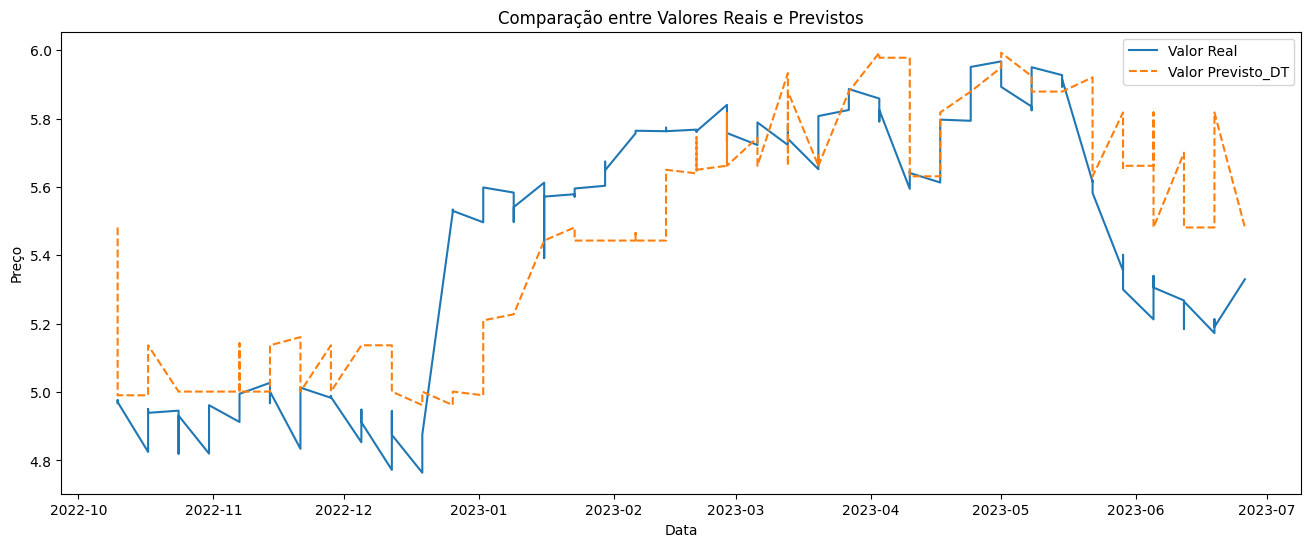

In [506]:
# Plotando os resultados
plt.figure(figsize=(16, 6))
plt.plot(df_previsoes['Valor Real'], label='Valor Real')
plt.plot(df_previsoes['Valor Previsto_DT'], label='Valor Previsto_DT', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

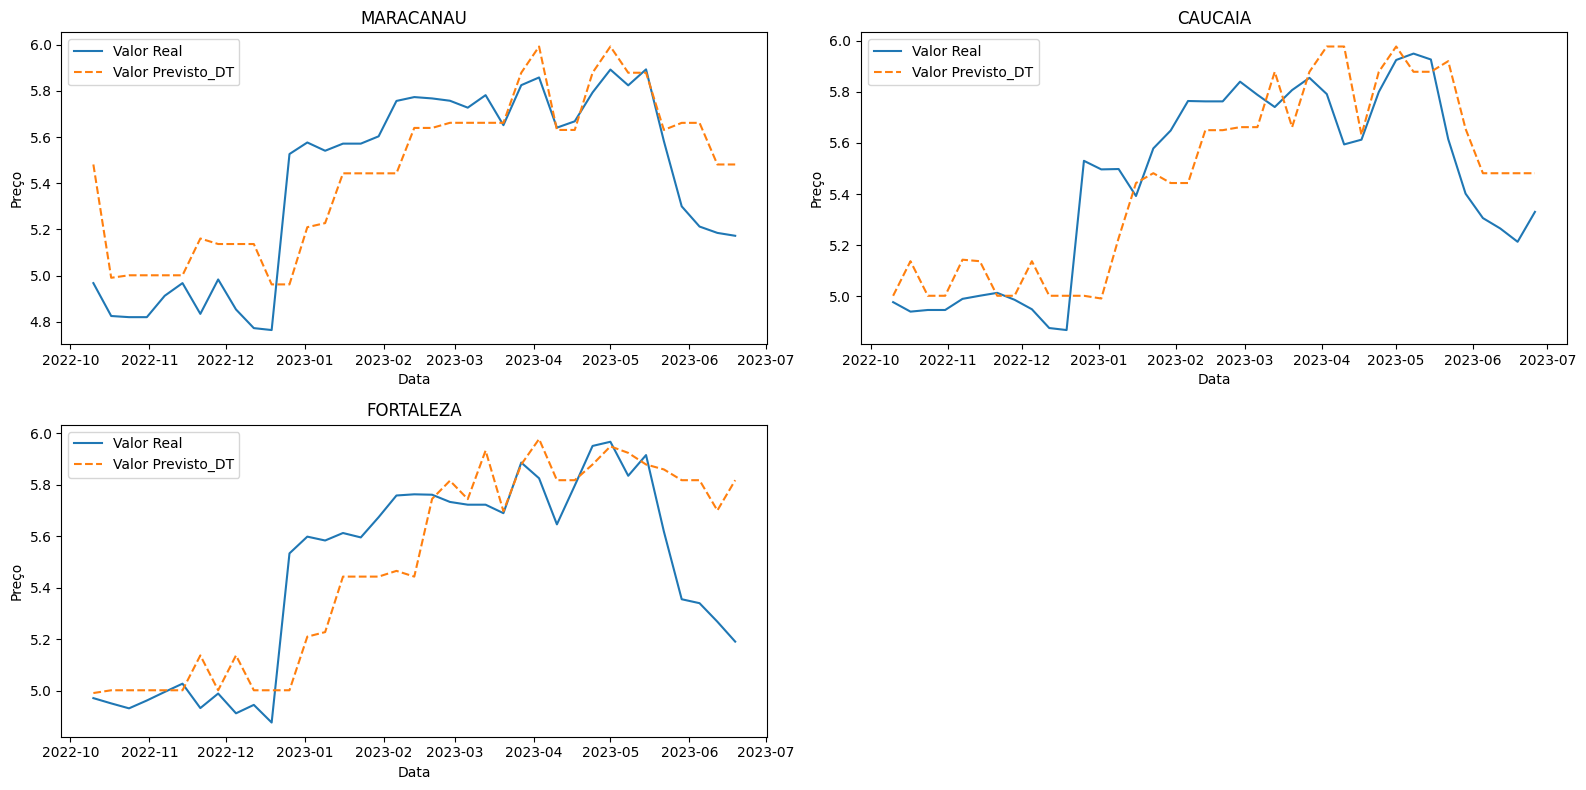

In [507]:
municipios = df_previsoes['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # Número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas, ajustado para o número total de municípios

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Achatar a matriz de eixos para iteração

for i, municipio in enumerate(municipios):
    df_municipio = df_previsoes[df_previsoes['Municipio'] == municipio]
    
    axes[i].plot(df_municipio['Valor Real'], label='Valor Real')
    axes[i].plot(df_municipio['Valor Previsto_DT'], label='Valor Previsto_DT', linestyle='--')
    axes[i].set_title(f'{municipio}')
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Preço')
    axes[i].legend()

# Removendo eixos vazios, caso haja
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



## Residuos do Modelo

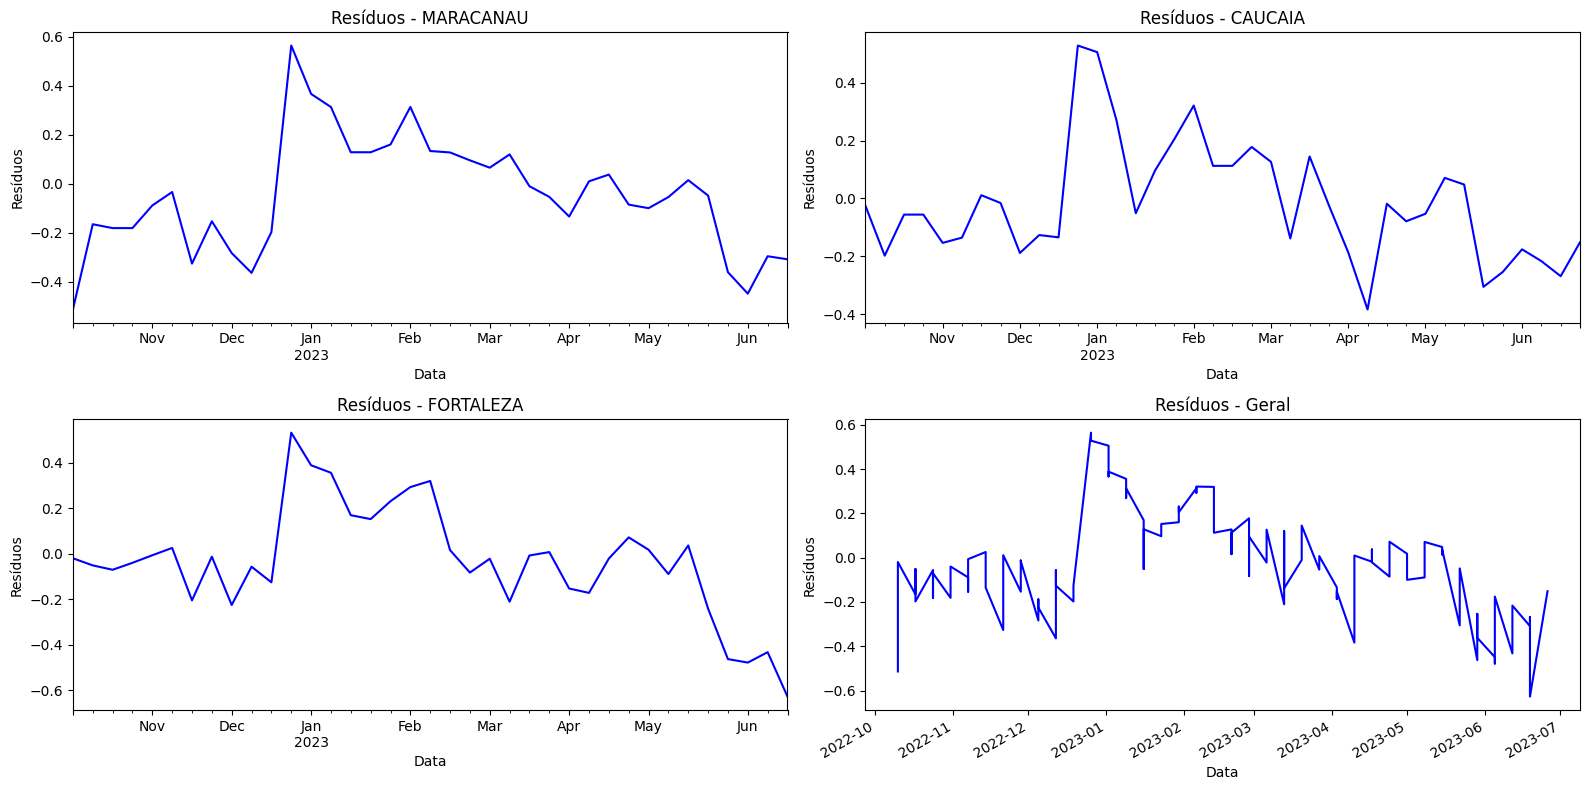

In [508]:
# Supondo que o nome da coluna com os municípios seja 'Municipio'
municipios = df_residuos['Municipio'].unique()

# Definindo o número de subplots
n_municipios = len(municipios) + 1  # Adiciona 1 para incluir o gráfico geral
n_cols = 2  # Definindo o número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas necessário

# Criando a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Garantir que 'axes' seja sempre uma matriz 2D, mesmo com poucos subplots
if n_rows == 1:
    axes = [axes]  # Se houver apenas uma linha, transforme axes em uma lista

# Definindo os gráficos manualmente
# Gráfico para o primeiro município
df_municipio1 = df_residuos[df_residuos['Municipio'] == municipios[0]]
df_municipio1[['resid_DT']].plot(ax=axes[0, 0], color='b', legend=False)
axes[0, 0].set_title(f"Resíduos - {municipios[0]}")
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduos')

# Gráfico para o segundo município
df_municipio2 = df_residuos[df_residuos['Municipio'] == municipios[1]]
df_municipio2[['resid_DT']].plot(ax=axes[0, 1], color='b', legend=False)
axes[0, 1].set_title(f"Resíduos - {municipios[1]}")
axes[0, 1].set_xlabel('Data')
axes[0, 1].set_ylabel('Resíduos')

# Se houver um terceiro município, plotá-lo na segunda linha
if n_municipios > 2:
    df_municipio3 = df_residuos[df_residuos['Municipio'] == municipios[2]]
    df_municipio3[['resid_DT']].plot(ax=axes[1, 0], color='b', legend=False)
    axes[1, 0].set_title(f"Resíduos - {municipios[2]}")
    axes[1, 0].set_xlabel('Data')
    axes[1, 0].set_ylabel('Resíduos')

# Plotando o gráfico geral
df_residuos[['resid_DT']].plot(ax=axes[1, 1], color='b', legend=False)
axes[1, 1].set_title("Resíduos - Geral")
axes[1, 1].set_xlabel('Data')
axes[1, 1].set_ylabel('Resíduos')

# Removendo eixos vazios, caso haja
for j in range(n_municipios, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


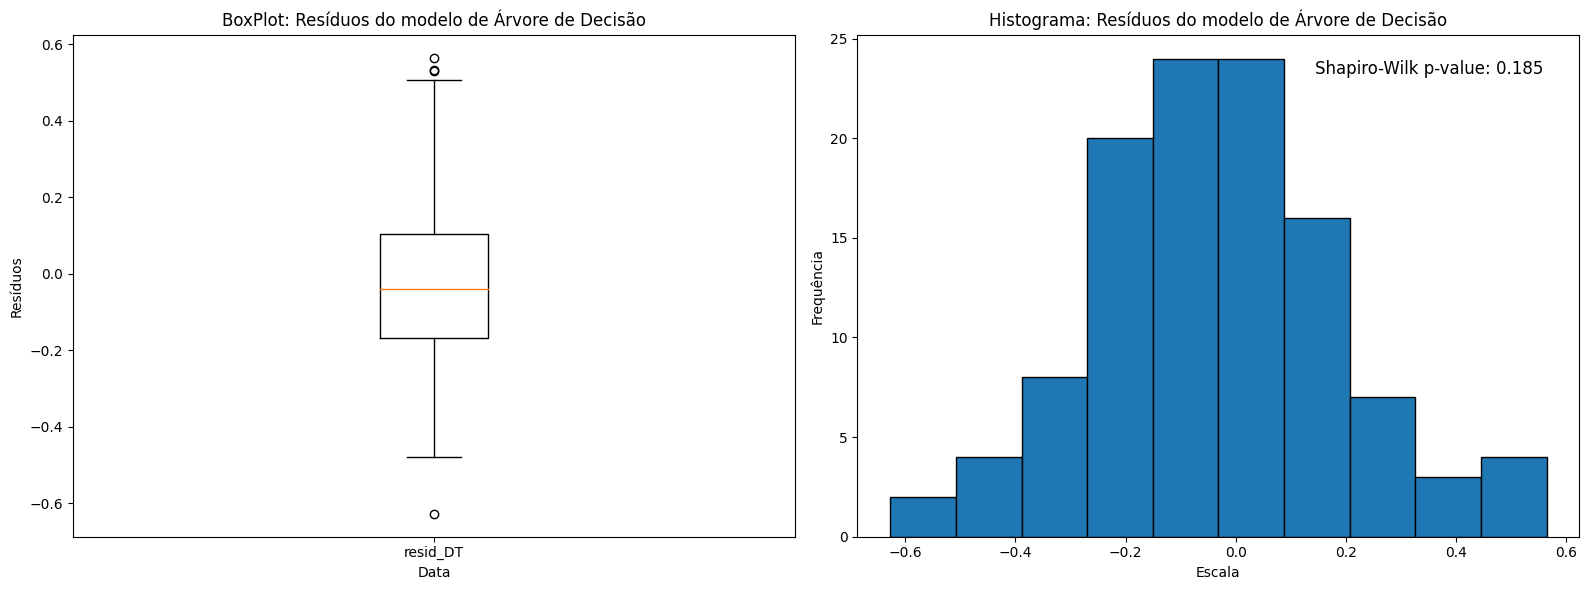

In [509]:
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Calcular os resíduos

# Criar uma figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
axes[0].boxplot(df_residuos[['resid_DT']].iloc[1:, :], labels=['resid_DT'])
axes[0].set_title("BoxPlot: Resíduos do modelo de Árvore de Decisão")
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Resíduos')

# Plotar o histograma no segundo subplot
df_residuos['resid_DT'].plot(kind='hist', ax=axes[1], edgecolor='black')
axes[1].set_title("Histograma: Resíduos do modelo de Árvore de Decisão")
axes[1].set_xlabel('Escala')
axes[1].set_ylabel('Frequência')

# Realizar o teste de Shapiro-Wilk e adicionar o valor p ao histograma
stat, p_value = shapiro(df_residuos['resid_DT'].dropna())
axes[1].text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


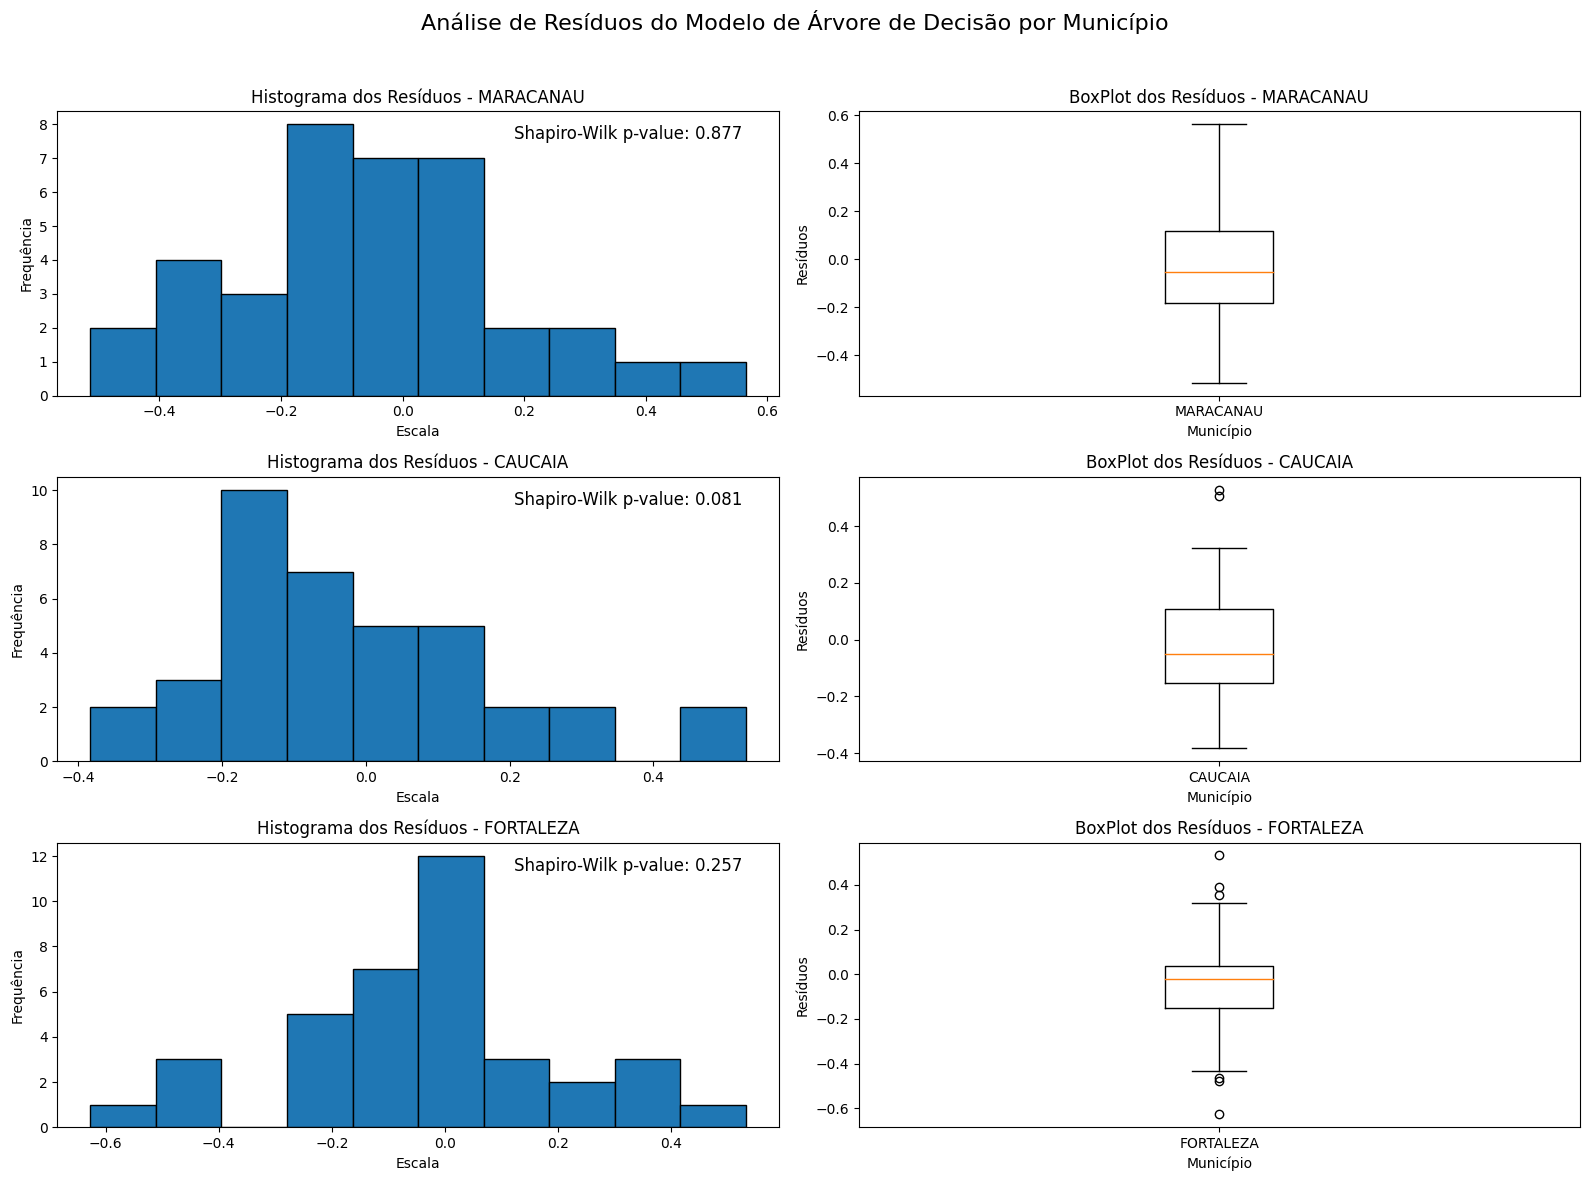

In [510]:
from scipy.stats import shapiro

# Supondo que o nome da coluna com os municípios seja 'Municipio'
municipios = df_residuos['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # 2 gráficos por linha (histograma e boxplot)
n_rows = n_municipios  # Uma linha por município

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

for i, municipio in enumerate(municipios):
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio]
    
    # Plotando o histograma dos resíduos
    ax_hist = axes[i, 0]
    df_municipio['resid_DT'].plot(kind='hist', ax=ax_hist,edgecolor='black')
    ax_hist.set_title(f"Histograma dos Resíduos - {municipio}")
    ax_hist.set_xlabel('Escala')
    ax_hist.set_ylabel('Frequência')

    # Realizando o teste de Shapiro-Wilk
    stat, p_value = shapiro(df_municipio['resid_DT'].dropna())
    ax_hist.text(0.95, 0.95, f'Shapiro-Wilk p-value: {p_value:.3f}', transform=ax_hist.transAxes,
                 fontsize=12, verticalalignment='top', horizontalalignment='right')

    # Plotando o boxplot dos resíduos
    ax_box = axes[i, 1]
    ax_box.boxplot(df_municipio['resid_DT'].dropna(), labels=[f'{municipio}'])
    ax_box.set_title(f"BoxPlot dos Resíduos - {municipio}")
    ax_box.set_xlabel('Município')
    ax_box.set_ylabel('Resíduos')

plt.suptitle("Análise de Resíduos do Modelo de Árvore de Decisão por Município", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Modelagem dos residuos

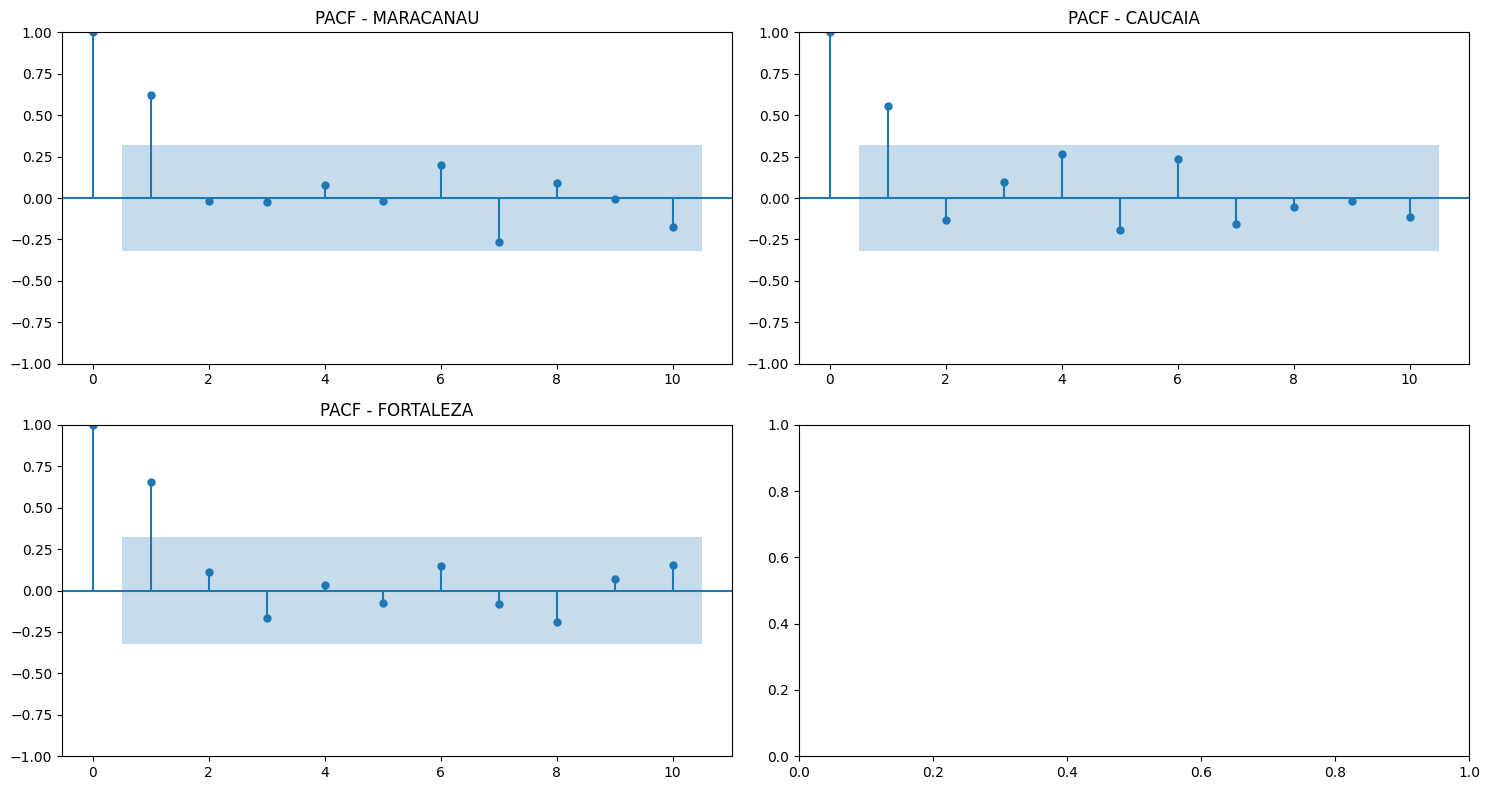

In [511]:

from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Lista de municípios únicos no DataFrame
municipios = df_residuos['Municipio'].unique()

# Definindo o número de colunas e linhas para o layout dos subplots
n_cols = 2  # número de colunas
n_rows = (len(municipios) + 1) // n_cols  # número de linhas

# Criando uma figura para os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Iterando sobre os municípios e subplots
for i, municipio in enumerate(municipios):
    # Filtrando os resíduos para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio]
    
    # Identificando a posição do subplot
    row = i // n_cols
    col = i % n_cols
    
    # Plotando a PACF no subplot correspondente
    plot_pacf(df_municipio['resid_DT'], lags=10, ax=axes[row, col], title=f'PACF - {municipio}')
    
# Ajustando o layout para não sobrepor os subplots
plt.tight_layout()
plt.show()


In [512]:


from statsmodels.tsa.ar_model import AutoReg

# Dicionário para armazenar modelos e previsões para cada município
modelos_residuos = {}
previsoes_ajustadas = {}

# Iterar sobre cada município
for municipio in df_residuos['Municipio'].unique():
    # Filtrar os dados para o município atual
    df_municipio = df_residuos[df_residuos['Municipio'] == municipio].copy()
    
    # Configurar a frequência da série temporal explicitamente
    df_municipio = df_municipio.asfreq('W-MON')
    
    # Modelando os resíduos
    model_residuos_pacf = AutoReg(df_municipio['resid_DT'], lags=[1, 2]).fit()
    
    # Prevendo os resíduos
    df_municipio['resid_pred_pacf'] = model_residuos_pacf.predict(start=2, end=len(df_municipio)-1)
    
    # Salvando o modelo e as previsões
    modelos_residuos[municipio] = model_residuos_pacf
    previsoes_ajustadas[municipio] = df_municipio['resid_pred_pacf']

# Ajustando as previsões no DataFrame original
df_residuos['resid_pred_pacf'] = df_residuos.apply(
    lambda row: previsoes_ajustadas[row['Municipio']].get(row.name, pd.NA), axis=1
)

df_previsoes['Valor Ajustado_DT_PACF'] = df_previsoes['Valor Previsto_DT'] + df_residuos['resid_pred_pacf']


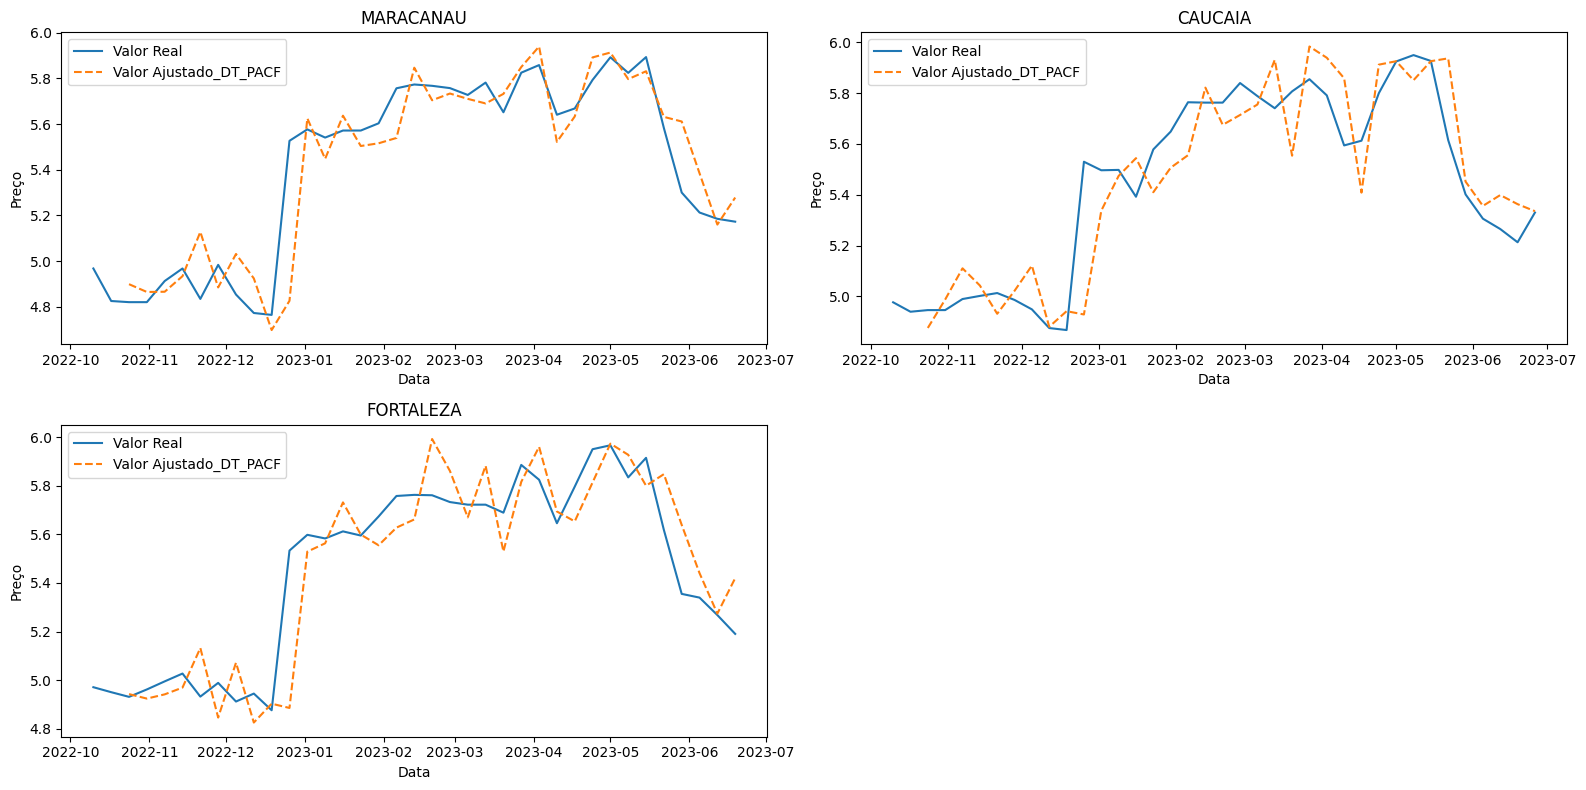

In [513]:
municipios = df_previsoes['Municipio'].unique()

# Definindo o número de linhas e colunas da grade
n_municipios = len(municipios)
n_cols = 2  # Número de colunas na grade
n_rows = math.ceil(n_municipios / n_cols)  # Número de linhas, ajustado para o número total de municípios

# Criando a figura e os eixos
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Achatar a matriz de eixos para iteração

for i, municipio in enumerate(municipios):
    df_municipio = df_previsoes[df_previsoes['Municipio'] == municipio]
    
    axes[i].plot(df_municipio['Valor Real'], label='Valor Real')
    axes[i].plot(df_municipio['Valor Ajustado_DT_PACF'], label='Valor Ajustado_DT_PACF', linestyle='--')
    axes[i].set_title(f'{municipio}')
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Preço')
    axes[i].legend()

# Removendo eixos vazios, caso haja
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()